# LAb -4-: Image Classification Using Deep Features
## Objective:
### • Extract deep features from images using two pre-trained models, VGG16 and ResNet, and use these features for image classification to compare their performance.

In [1]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. Data Loading and Preprocessing
Load your dataset of images and corresponding labels.

Ensure images are resized to the required dimensions (224x224 for VGG16).

Normalize the image data using preprocess_input.

In [2]:
image_dir = r"C:\Users\moham\OneDrive\Desktop\3CS IASD\Computer-Vision\lab3\UCMerced_LandUse\Images" 
class_names = [
    "agricultural", "airplane", "baseballdiamond", "beach", "buildings",
    "chaparral", "denseresidential", "forest", "freeway", "golfcourse",
    "harbor", "intersection", "mediumresidential", "mobilehomepark", "overpass",
    "parkinglot", "river", "runway", "sparseresidential", "storagetanks",
    "tenniscourt"
]

images = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(image_dir, class_name)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            if image_file.endswith(".tif"):
                image_path = os.path.join(class_dir, image_file)
                try:
                    img = cv2.imread(image_path)
                    if img is not None:
                        # Resize images to a consistent size if there are variations:
                        img = cv2.resize(img, (256, 256))  # Ensure all images are 256x256

                        images.append(img)
                        labels.append(class_name)
                except Exception as e:
                    print(f"Error loading or resizing image {image_path}: {e}")



# Convert to NumPy arrays (after ensuring consistent sizes)
images = np.array(images)
labels = np.array(labels)

In [3]:
labels

array(['agricultural', 'agricultural', 'agricultural', ..., 'tenniscourt',
       'tenniscourt', 'tenniscourt'], dtype='<U17')

### • Dataset Splitting:
– Split the dataset into a training set and a testing set. A common split ratio is 80% for training and 20% for testing.

– Ensure that the split maintains a balance of images from different categories.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")

def resize_images(images, target_size=(224, 224)):
    resized_images = np.array([cv2.resize(img, target_size) for img in images])
    return resized_images

# Resize train and test images
X_train_resized = resize_images(X_train)
X_test_resized = resize_images(X_test)

# Preprocess the resized images
X_train_preprocessed = preprocess_input(X_train_resized)
X_test_preprocessed = preprocess_input(X_test_resized)

print("Images resized and preprocessed successfully.")

Train set size: 1680, Test set size: 420
Images resized and preprocessed successfully.


### 2. Deep Feature Extraction
Load the VGG16 model with pre-trained weights and extract features from the last fully connected layer (fc2).

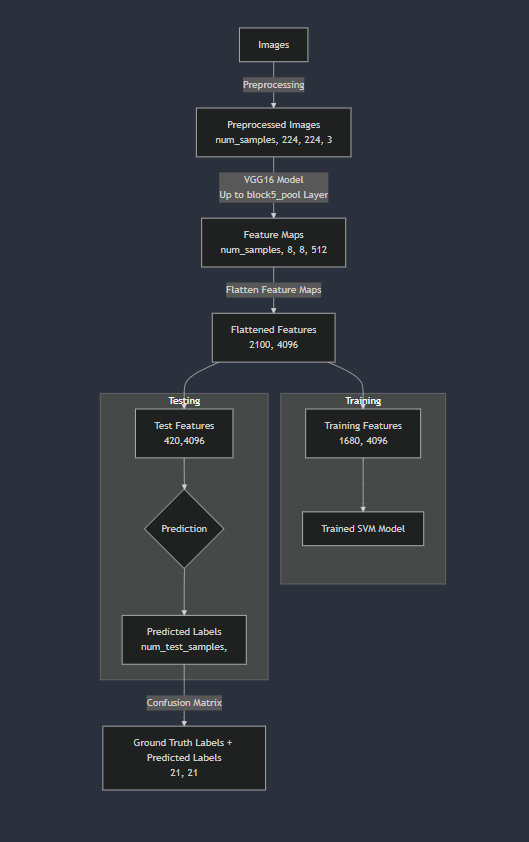

In [6]:
# Load VGG16 model with ImageNet weights
vgg16_model = VGG16(weights='imagenet', include_top=True)

# Create a feature extractor model using the `fc2` layer
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('fc2').output)
print("VGG16 model loaded successfully. Using fc2 layer for feature extraction.")

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 180s 0us/step
VGG16 model loaded successfully. Using fc2 layer for feature extraction.


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 256, 256, 3)

In [8]:
# Extract features
X_train_features = feature_extractor.predict(X_train_preprocessed)
X_test_features = feature_extractor.predict(X_test_preprocessed)
print(f"Training features extracted: {X_train_features.shape}")
print(f"Testing features extracted: {X_test_features.shape}")

VGG16 model loaded successfully. Using fc2 layer for feature extraction.
53/53 ━━━━━━━━━━━━━━━━━━━━ 709s 13s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 180s 13s/step
Training features extracted: (1680, 4096)
Testing features extracted: (420, 4096)


### 3. SVM Classifier Training
Train an SVM classifier using the extracted features and corresponding labels.

In [9]:
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_features, y_train)

# Evaluate on the test set
y_pred = svm_model.predict(X_test_features)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        21
         airplane       1.00      0.88      0.94        17
  baseballdiamond       1.00      0.92      0.96        26
            beach       0.95      1.00      0.98        20
        buildings       0.70      0.67      0.68        24
        chaparral       1.00      1.00      1.00        26
 denseresidential       0.74      0.78      0.76        18
           forest       1.00      1.00      1.00        17
          freeway       0.90      1.00      0.95        18
       golfcourse       0.93      0.88      0.90        16
           harbor       1.00      1.00      1.00        20
     intersection       0.89      0.89      0.89        18
mediumresidential       0.65      0.87      0.74        15
   mobilehomepark       1.00      0.93      0.96        27
         overpass       0.96      1.00      0.98        23
       parkinglot       1.00   

### 4. Performance Evaluation
Compute accuracy and visualize the confusion matrix.

In [10]:
# Compute accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 91.90%


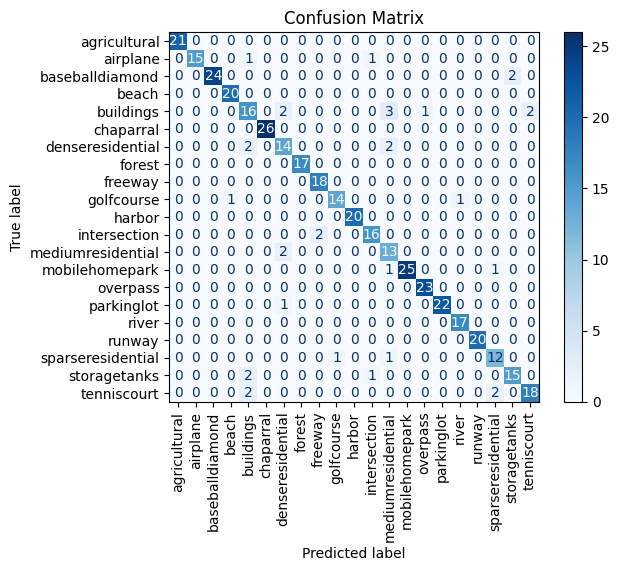

In [12]:
# Plot confusion matrix
def plot_confusion_matrix(test_labels, predictions, class_names):
    cm = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


unique_labels = np.unique(labels)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, unique_labels)